This notebook uses MNIST dataset to compare following optimizers: <br\>

2. Mini-batch SGD
3. Momentum
4. Nesterov Momentum
5. Adagrad
6. Adam

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**create dataset and dataloader**

In [3]:
class MnistDataset(Dataset):
    """MNIST dataset"""
    def __init__(self, train_path, test_path = None):
        """
        Args:
            train_path(string): path to the csv file with features
            train_label_path(string): path to the csv file with train labels
        """
        self.data = np.array(pd.read_csv(train_path))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = self.data[idx][1:]
        label_map = {}
        y = self.data[idx][0]
        return {"feature": torch.from_numpy(X).float()/255, "label": torch.LongTensor(np.array([y]))}

In [4]:
#take a look at first 3 data
mnist_dataset = MnistDataset(train_path="mnist_train.csv")
print(len(mnist_dataset))
for i in range(3):
    sample = mnist_dataset[i]
    print(i, sample['feature'].shape, sample['label'].shape)

60000
0 torch.Size([784]) torch.Size([1])
1 torch.Size([784]) torch.Size([1])
2 torch.Size([784]) torch.Size([1])


In [5]:
batch_loader = DataLoader(mnist_dataset, batch_size = 128, shuffle=True)
sample = next(iter(batch_loader))
print(sample['feature'].shape, sample['label'].shape)

torch.Size([128, 784]) torch.Size([128, 1])


**A vanilla net**, reference from: https://course.fast.ai/lessons/lesson7.html

In [6]:
class VanillaNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
    def forward(self, x):
        for layer in self.layers:
            h = layer(x)
            x = F.relu(h)
        return F.log_softmax(h, dim=1)

**Setting training parameters and start training**

In [7]:
EPOCHS = 3
criterion = nn.NLLLoss()

**1. Mini-batch SGD**

In [8]:
#initialize network
VNet = VanillaNet([784, 100, 100, 10])
wbs = [(l.weight, l.bias) for l in VNet.layers]

#keep track of loss and setup learning rate
losses = list()
lr = 1e-3

#training 
for epoch in range(EPOCHS):
    print('EPOCH: {}'.format(epoch))
    for batch in iter(batch_loader):
        x, y = batch['feature'], batch['label']
        x, y = Variable(x), Variable(y)
        output = VNet(x)
        
        #compute loss
        loss = criterion(output, y.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        #weight update using SGD
        for w,b in wbs:
            w.data -= lr*w.grad.data
            b.data -= lr*b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()

EPOCH: 0
EPOCH: 1
EPOCH: 2


Text(0.5,1,'mini-batch SGD')

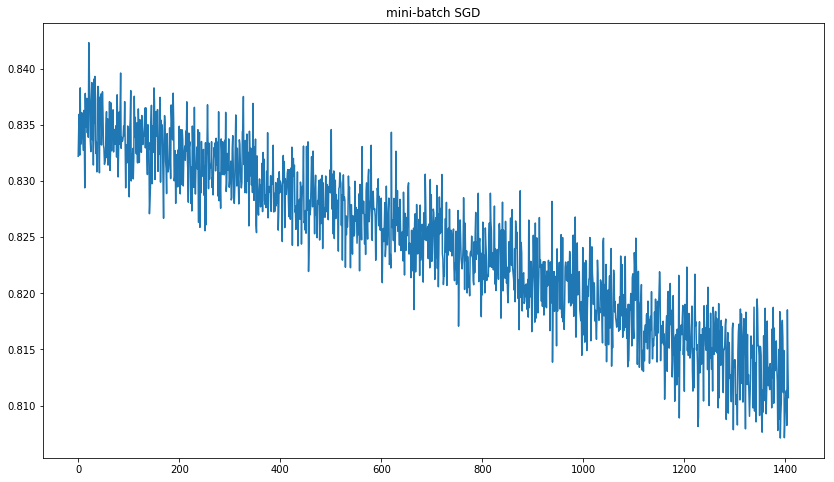

In [9]:
sgd_losses = [np.log(l.item()) for l in losses]
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(sgd_losses)
ax.set_title("mini-batch SGD")

**2. SGD with momentum**

In [10]:
#initialize network
wbs = [(l.weight, l.bias) for l in VNet.layers]

#keep track of loss, set learning rate, and gamma to 0.9 as usual, and initialize velocity to 0
momentum_losses = list()
lr = 1e-3
gamma = 0.9
v_w = [0 for i in range(len(wbs))]
v_b = [0 for i in range(len(wbs))]

#training 
for epoch in range(EPOCHS):
    print('EPOCH: {}'.format(epoch))
    for batch in iter(batch_loader):
        x, y = batch['feature'], batch['label']
        x, y = Variable(x), Variable(y)
        output = VNet(x)
        
        #compute loss
        loss = criterion(output, y.squeeze(-1))
        momentum_losses.append(loss)
        loss.backward()
        
        #weight update using momentum
        for i, wb in enumerate(wbs):
            w, b = wb
            v_w[i] = gamma * v_w[i] + (1-gamma)* w.grad.data
            v_b[i] = gamma * v_b[i] + (1-gamma)* b.grad.data
            #perform updates
            w.data -= lr*v_w[i]
            b.data -= lr*v_b[i]
            #zero gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

EPOCH: 0
EPOCH: 1
EPOCH: 2


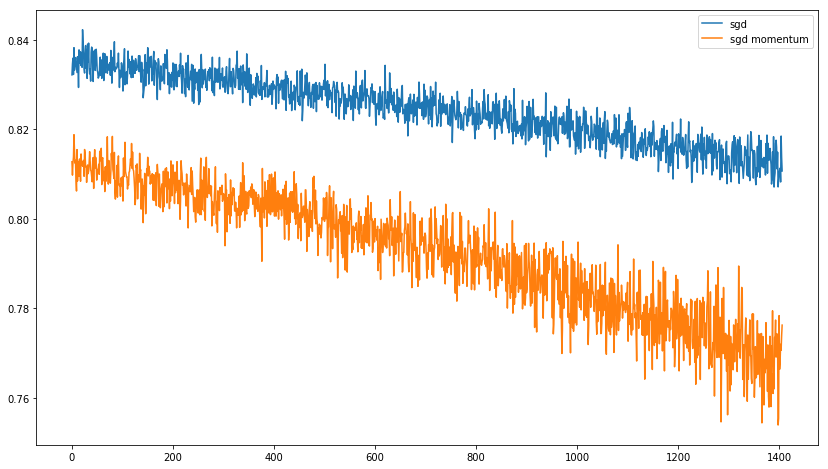

In [11]:
sgd_momentum_losses = [np.log(l.item()) for l in momentum_losses]
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(sgd_losses)
ax.plot(sgd_momentum_losses)
ax.legend(['sgd', 'sgd momentum'])

**4. Adagrad**

In [20]:
#initialize network
wbs = [(l.weight, l.bias) for l in VNet.layers]

#keep track of loss, set learning rate, and gamma to 0.9 as usual, and initialize velocity to 0
ada_losses = list()
lr = 1e-3
epsilon = 1e-6

w_sum = [torch.zeros(wbs[i][0].size()) for i in range(len(wbs))]
b_sum = [torch.zeros(wbs[i][1].size()) for i in range(len(wbs))]
#training 
for epoch in range(EPOCHS):
    print('EPOCH: {}'.format(epoch))
    for batch in iter(batch_loader):
        x, y = batch['feature'], batch['label']
        x, y = Variable(x), Variable(y)
        output = VNet(x)
        
        #compute loss
        loss = criterion(output, y.squeeze(-1))
        ada_losses.append(loss)
        loss.backward()
        
        #weight update using adagrad
        #implementation follows from: http://cs231n.github.io/neural-networks-3/
        for i, wb in enumerate(wbs):
            w,b = wb
            #perform updates 
            w.data -= lr*w.grad.data/(torch.sqrt(w_sum[i]) + epsilon)
            b.data -= lr*b.grad.data/(torch.sqrt(b_sum[i]) + epsilon)
            
            w_sum[i] += w.grad.data * w.grad.data
            b_sum[i] += b.grad.data * b.grad.data
            #zero gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

EPOCH: 0
EPOCH: 1
EPOCH: 2


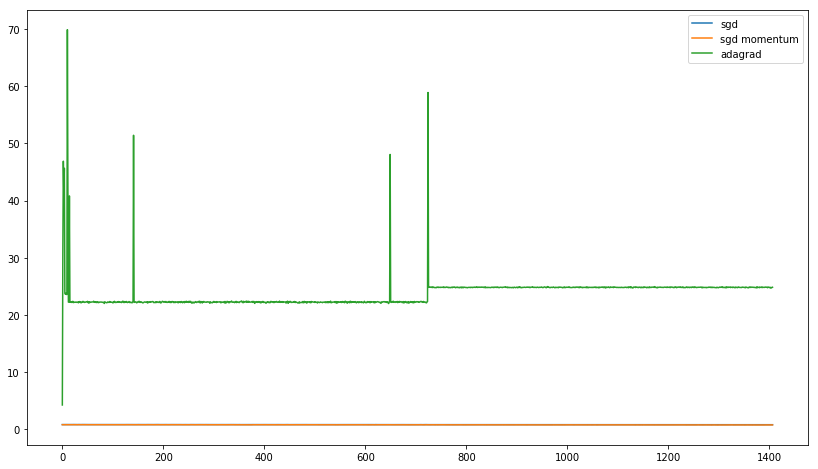

In [21]:
ada_losses = [np.log(l.item()) for l in ada_losses]
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(sgd_losses)
ax.plot(sgd_momentum_losses)
ax.plot(ada_losses)
ax.legend(['sgd', 'sgd momentum', 'adagrad'])

**3. Nesterov**

In [ ]:
#initialize network
wbs = [(l.weight, l.bias) for l in VNet.layers]

#keep track of loss, set learning rate, and gamma to 0.9 as usual, and initialize velocity to 0
nes_losses = list()
lr = 1e-3
gamma = 0.9
v_w = [0 for i in range(len(wbs))]
v_b = [0 for i in range(len(wbs))]

#training 
for epoch in range(EPOCHS):
    print('EPOCH: {}'.format(epoch))
    for batch in iter(batch_loader):
        x, y = batch['feature'], batch['label']
        x, y = Variable(x), Variable(y)
        output = VNet(x)
        
        #compute loss
        loss = criterion(output, y.squeeze(-1))
        nes_losses.append(loss)
        
        #update weights 
        w_old = w.data
        w.data -= 
        
        #weight update using SGD
        for i, wb in enumerate(wbs):
            w, b = wb
            v_w[i] = gamma * v_w[i] + (1-gamma)* w.grad.data
            v_b[i] = gamma * v_b[i] + (1-gamma)* b.grad.data
            #perform updates
            w.data -= lr*v_w[i]
            b.data -= lr*v_b[i]
            #zero gradients
            w.grad.data.zero_()
            b.grad.data.zero_()